# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  212992/11490434 [..............................] - ETA: 3s

 2326528/11490434 [=====>........................] - ETA: 0s

 7839744/11490434 [===================>..........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 1:00:39 - loss: 0.6939

  12/1875 [..............................] - ETA: 8s - loss: 0.6369     

  24/1875 [..............................] - ETA: 8s - loss: 0.5668

  39/1875 [..............................] - ETA: 7s - loss: 0.5095

  52/1875 [..............................] - ETA: 7s - loss: 0.4764

  64/1875 [>.............................] - ETA: 7s - loss: 0.4536

  82/1875 [>.............................] - ETA: 6s - loss: 0.4280

  95/1875 [>.............................] - ETA: 6s - loss: 0.4136

 111/1875 [>.............................] - ETA: 6s - loss: 0.3992

 126/1875 [=>............................] - ETA: 6s - loss: 0.3879

 144/1875 [=>............................] - ETA: 6s - loss: 0.3765

 160/1875 [=>............................] - ETA: 6s - loss: 0.3678

 177/1875 [=>............................] - ETA: 6s - loss: 0.3595

 198/1875 [==>...........................] - ETA: 5s - loss: 0.3505

 218/1875 [==>...........................] - ETA: 5s - loss: 0.3430

 232/1875 [==>...........................] - ETA: 5s - loss: 0.3381

 246/1875 [==>...........................] - ETA: 5s - loss: 0.3336

 265/1875 [===>..........................] - ETA: 5s - loss: 0.3280

 282/1875 [===>..........................] - ETA: 5s - loss: 0.3233

 295/1875 [===>..........................] - ETA: 5s - loss: 0.3200

 307/1875 [===>..........................] - ETA: 5s - loss: 0.3170

 328/1875 [====>.........................] - ETA: 5s - loss: 0.3122

 346/1875 [====>.........................] - ETA: 5s - loss: 0.3083

 358/1875 [====>.........................] - ETA: 5s - loss: 0.3059

 373/1875 [====>.........................] - ETA: 5s - loss: 0.3030

 387/1875 [=====>........................] - ETA: 5s - loss: 0.3003

 402/1875 [=====>........................] - ETA: 5s - loss: 0.2976

 414/1875 [=====>........................] - ETA: 5s - loss: 0.2956

 430/1875 [=====>........................] - ETA: 4s - loss: 0.2929

 444/1875 [======>.......................] - ETA: 4s - loss: 0.2907

 462/1875 [======>.......................] - ETA: 4s - loss: 0.2879

 477/1875 [======>.......................] - ETA: 4s - loss: 0.2857

 493/1875 [======>.......................] - ETA: 4s - loss: 0.2835

 509/1875 [=======>......................] - ETA: 4s - loss: 0.2813

 529/1875 [=======>......................] - ETA: 4s - loss: 0.2787

 546/1875 [=======>......................] - ETA: 4s - loss: 0.2765

 563/1875 [========>.....................] - ETA: 4s - loss: 0.2745

 578/1875 [========>.....................] - ETA: 4s - loss: 0.2727

 593/1875 [========>.....................] - ETA: 4s - loss: 0.2710

 607/1875 [========>.....................] - ETA: 4s - loss: 0.2695

 621/1875 [========>.....................] - ETA: 4s - loss: 0.2680

 636/1875 [=========>....................] - ETA: 4s - loss: 0.2664

 653/1875 [=========>....................] - ETA: 4s - loss: 0.2647

 669/1875 [=========>....................] - ETA: 4s - loss: 0.2631

 679/1875 [=========>....................] - ETA: 4s - loss: 0.2621

 697/1875 [==========>...................] - ETA: 3s - loss: 0.2605

 714/1875 [==========>...................] - ETA: 3s - loss: 0.2589

 730/1875 [==========>...................] - ETA: 3s - loss: 0.2575

 742/1875 [==========>...................] - ETA: 3s - loss: 0.2564

 758/1875 [===========>..................] - ETA: 3s - loss: 0.2551

 773/1875 [===========>..................] - ETA: 3s - loss: 0.2539

 788/1875 [===========>..................] - ETA: 3s - loss: 0.2526

 804/1875 [===========>..................] - ETA: 3s - loss: 0.2514

 819/1875 [============>.................] - ETA: 3s - loss: 0.2502

 835/1875 [============>.................] - ETA: 3s - loss: 0.2490

 850/1875 [============>.................] - ETA: 3s - loss: 0.2479

 864/1875 [============>.................] - ETA: 3s - loss: 0.2469

 879/1875 [=============>................] - ETA: 3s - loss: 0.2458

 892/1875 [=============>................] - ETA: 3s - loss: 0.2449

 907/1875 [=============>................] - ETA: 3s - loss: 0.2439

 927/1875 [=============>................] - ETA: 3s - loss: 0.2426

 940/1875 [==============>...............] - ETA: 3s - loss: 0.2417

 955/1875 [==============>...............] - ETA: 3s - loss: 0.2407

 966/1875 [==============>...............] - ETA: 3s - loss: 0.2401

 980/1875 [==============>...............] - ETA: 3s - loss: 0.2392

 993/1875 [==============>...............] - ETA: 3s - loss: 0.2384

1006/1875 [===============>..............] - ETA: 2s - loss: 0.2376

1018/1875 [===============>..............] - ETA: 2s - loss: 0.2369

1032/1875 [===============>..............] - ETA: 2s - loss: 0.2361

1047/1875 [===============>..............] - ETA: 2s - loss: 0.2352

1062/1875 [===============>..............] - ETA: 2s - loss: 0.2344

1077/1875 [================>.............] - ETA: 2s - loss: 0.2335

1095/1875 [================>.............] - ETA: 2s - loss: 0.2325

1109/1875 [================>.............] - ETA: 2s - loss: 0.2318

1125/1875 [=================>............] - ETA: 2s - loss: 0.2310

1137/1875 [=================>............] - ETA: 2s - loss: 0.2303

1155/1875 [=================>............] - ETA: 2s - loss: 0.2294

1167/1875 [=================>............] - ETA: 2s - loss: 0.2288

1186/1875 [=================>............] - ETA: 2s - loss: 0.2279

1200/1875 [==================>...........] - ETA: 2s - loss: 0.2272

1214/1875 [==================>...........] - ETA: 2s - loss: 0.2265

1228/1875 [==================>...........] - ETA: 2s - loss: 0.2259

1245/1875 [==================>...........] - ETA: 2s - loss: 0.2251

1264/1875 [===================>..........] - ETA: 2s - loss: 0.2242

1277/1875 [===================>..........] - ETA: 2s - loss: 0.2236

1289/1875 [===================>..........] - ETA: 2s - loss: 0.2231

1302/1875 [===================>..........] - ETA: 1s - loss: 0.2225

1318/1875 [====================>.........] - ETA: 1s - loss: 0.2218

1337/1875 [====================>.........] - ETA: 1s - loss: 0.2210

1351/1875 [====================>.........] - ETA: 1s - loss: 0.2204

1363/1875 [====================>.........] - ETA: 1s - loss: 0.2199

1379/1875 [=====================>........] - ETA: 1s - loss: 0.2192

1397/1875 [=====================>........] - ETA: 1s - loss: 0.2185

1413/1875 [=====================>........] - ETA: 1s - loss: 0.2179

1430/1875 [=====================>........] - ETA: 1s - loss: 0.2172

1449/1875 [======================>.......] - ETA: 1s - loss: 0.2164

1471/1875 [======================>.......] - ETA: 1s - loss: 0.2156

1489/1875 [======================>.......] - ETA: 1s - loss: 0.2149

1509/1875 [=======================>......] - ETA: 1s - loss: 0.2142

1527/1875 [=======================>......] - ETA: 1s - loss: 0.2135

1544/1875 [=======================>......] - ETA: 1s - loss: 0.2129

1562/1875 [=======================>......] - ETA: 1s - loss: 0.2123

1576/1875 [========================>.....] - ETA: 1s - loss: 0.2118

1592/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1607/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1623/1875 [========================>.....] - ETA: 0s - loss: 0.2102

1640/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1656/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1674/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1690/1875 [==========================>...] - ETA: 0s - loss: 0.2080

1711/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1729/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1750/1875 [===========================>..] - ETA: 0s - loss: 0.2061

1770/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1791/1875 [===========================>..] - ETA: 0s - loss: 0.2049

1808/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1830/1875 [============================>.] - ETA: 0s - loss: 0.2037

1847/1875 [============================>.] - ETA: 0s - loss: 0.2032

1864/1875 [============================>.] - ETA: 0s - loss: 0.2028

1875/1875 [==============================] - 8s 3ms/step - loss: 0.2024


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1180

  20/1875 [..............................] - ETA: 5s - loss: 0.1135

  36/1875 [..............................] - ETA: 5s - loss: 0.1124

  57/1875 [..............................] - ETA: 5s - loss: 0.1117

  77/1875 [>.............................] - ETA: 4s - loss: 0.1113

  97/1875 [>.............................] - ETA: 4s - loss: 0.1110

 119/1875 [>.............................] - ETA: 4s - loss: 0.1108

 130/1875 [=>............................] - ETA: 4s - loss: 0.1107

 148/1875 [=>............................] - ETA: 4s - loss: 0.1105

 162/1875 [=>............................] - ETA: 5s - loss: 0.1104

 181/1875 [=>............................] - ETA: 4s - loss: 0.1103

 197/1875 [==>...........................] - ETA: 4s - loss: 0.1102

 210/1875 [==>...........................] - ETA: 5s - loss: 0.1102

 227/1875 [==>...........................] - ETA: 4s - loss: 0.1101

 244/1875 [==>...........................] - ETA: 4s - loss: 0.1100

 259/1875 [===>..........................] - ETA: 4s - loss: 0.1100

 275/1875 [===>..........................] - ETA: 4s - loss: 0.1099

 289/1875 [===>..........................] - ETA: 4s - loss: 0.1098

 304/1875 [===>..........................] - ETA: 4s - loss: 0.1098

 321/1875 [====>.........................] - ETA: 4s - loss: 0.1097

 337/1875 [====>.........................] - ETA: 4s - loss: 0.1097

 355/1875 [====>.........................] - ETA: 4s - loss: 0.1096

 368/1875 [====>.........................] - ETA: 4s - loss: 0.1096

 387/1875 [=====>........................] - ETA: 4s - loss: 0.1095

 402/1875 [=====>........................] - ETA: 4s - loss: 0.1094

 420/1875 [=====>........................] - ETA: 4s - loss: 0.1094

 433/1875 [=====>........................] - ETA: 4s - loss: 0.1093

 443/1875 [======>.......................] - ETA: 4s - loss: 0.1093

 456/1875 [======>.......................] - ETA: 4s - loss: 0.1092

 470/1875 [======>.......................] - ETA: 4s - loss: 0.1092

 484/1875 [======>.......................] - ETA: 4s - loss: 0.1091

 500/1875 [=======>......................] - ETA: 4s - loss: 0.1091

 514/1875 [=======>......................] - ETA: 4s - loss: 0.1090

 528/1875 [=======>......................] - ETA: 4s - loss: 0.1090

 542/1875 [=======>......................] - ETA: 4s - loss: 0.1089

 558/1875 [=======>......................] - ETA: 4s - loss: 0.1089

 576/1875 [========>.....................] - ETA: 4s - loss: 0.1088

 591/1875 [========>.....................] - ETA: 4s - loss: 0.1088

 606/1875 [========>.....................] - ETA: 4s - loss: 0.1088

 618/1875 [========>.....................] - ETA: 4s - loss: 0.1087

 632/1875 [=========>....................] - ETA: 4s - loss: 0.1087

 645/1875 [=========>....................] - ETA: 4s - loss: 0.1087

 655/1875 [=========>....................] - ETA: 4s - loss: 0.1086

 670/1875 [=========>....................] - ETA: 4s - loss: 0.1086

 685/1875 [=========>....................] - ETA: 4s - loss: 0.1085

 699/1875 [==========>...................] - ETA: 4s - loss: 0.1085

 714/1875 [==========>...................] - ETA: 3s - loss: 0.1085

 728/1875 [==========>...................] - ETA: 3s - loss: 0.1084

 742/1875 [==========>...................] - ETA: 3s - loss: 0.1084

 756/1875 [===========>..................] - ETA: 3s - loss: 0.1084

 769/1875 [===========>..................] - ETA: 3s - loss: 0.1083

 780/1875 [===========>..................] - ETA: 3s - loss: 0.1083

 795/1875 [===========>..................] - ETA: 3s - loss: 0.1083

 808/1875 [===========>..................] - ETA: 3s - loss: 0.1082

 823/1875 [============>.................] - ETA: 3s - loss: 0.1082

 838/1875 [============>.................] - ETA: 3s - loss: 0.1081

 857/1875 [============>.................] - ETA: 3s - loss: 0.1081

 872/1875 [============>.................] - ETA: 3s - loss: 0.1081

 887/1875 [=============>................] - ETA: 3s - loss: 0.1080

 902/1875 [=============>................] - ETA: 3s - loss: 0.1080

 913/1875 [=============>................] - ETA: 3s - loss: 0.1080

 929/1875 [=============>................] - ETA: 3s - loss: 0.1079

 943/1875 [==============>...............] - ETA: 3s - loss: 0.1079

 961/1875 [==============>...............] - ETA: 3s - loss: 0.1078

 978/1875 [==============>...............] - ETA: 3s - loss: 0.1078

 993/1875 [==============>...............] - ETA: 3s - loss: 0.1078

1010/1875 [===============>..............] - ETA: 3s - loss: 0.1077

1027/1875 [===============>..............] - ETA: 2s - loss: 0.1077

1042/1875 [===============>..............] - ETA: 2s - loss: 0.1076

1057/1875 [===============>..............] - ETA: 2s - loss: 0.1076

1073/1875 [================>.............] - ETA: 2s - loss: 0.1076

1090/1875 [================>.............] - ETA: 2s - loss: 0.1075

1108/1875 [================>.............] - ETA: 2s - loss: 0.1075

1125/1875 [=================>............] - ETA: 2s - loss: 0.1074

1142/1875 [=================>............] - ETA: 2s - loss: 0.1074

1158/1875 [=================>............] - ETA: 2s - loss: 0.1074

1173/1875 [=================>............] - ETA: 2s - loss: 0.1073

1188/1875 [==================>...........] - ETA: 2s - loss: 0.1073

1205/1875 [==================>...........] - ETA: 2s - loss: 0.1073

1220/1875 [==================>...........] - ETA: 2s - loss: 0.1072

1238/1875 [==================>...........] - ETA: 2s - loss: 0.1072

1253/1875 [===================>..........] - ETA: 2s - loss: 0.1072

1270/1875 [===================>..........] - ETA: 2s - loss: 0.1071

1286/1875 [===================>..........] - ETA: 2s - loss: 0.1071

1303/1875 [===================>..........] - ETA: 1s - loss: 0.1070

1318/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1334/1875 [====================>.........] - ETA: 1s - loss: 0.1070

1350/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1366/1875 [====================>.........] - ETA: 1s - loss: 0.1069

1382/1875 [=====================>........] - ETA: 1s - loss: 0.1069

1400/1875 [=====================>........] - ETA: 1s - loss: 0.1068

1417/1875 [=====================>........] - ETA: 1s - loss: 0.1068

1430/1875 [=====================>........] - ETA: 1s - loss: 0.1068

1442/1875 [======================>.......] - ETA: 1s - loss: 0.1067

1456/1875 [======================>.......] - ETA: 1s - loss: 0.1067

1470/1875 [======================>.......] - ETA: 1s - loss: 0.1067

1485/1875 [======================>.......] - ETA: 1s - loss: 0.1067

1499/1875 [======================>.......] - ETA: 1s - loss: 0.1066

1510/1875 [=======================>......] - ETA: 1s - loss: 0.1066

1523/1875 [=======================>......] - ETA: 1s - loss: 0.1066

1537/1875 [=======================>......] - ETA: 1s - loss: 0.1065

1553/1875 [=======================>......] - ETA: 1s - loss: 0.1065

1569/1875 [========================>.....] - ETA: 1s - loss: 0.1065

1587/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1603/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1620/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1638/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1650/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1663/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1678/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1692/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1706/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1739/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1753/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1771/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1788/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1801/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1815/1875 [============================>.] - ETA: 0s - loss: 0.1060

1830/1875 [============================>.] - ETA: 0s - loss: 0.1060

1845/1875 [============================>.] - ETA: 0s - loss: 0.1060

1859/1875 [============================>.] - ETA: 0s - loss: 0.1059

1871/1875 [============================>.] - ETA: 0s - loss: 0.1059

1875/1875 [==============================] - 6s 3ms/step - loss: 0.1059


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1028

  16/1875 [..............................] - ETA: 6s - loss: 0.0972

  30/1875 [..............................] - ETA: 6s - loss: 0.0973

  45/1875 [..............................] - ETA: 6s - loss: 0.0974

  60/1875 [..............................] - ETA: 6s - loss: 0.0975

  76/1875 [>.............................] - ETA: 6s - loss: 0.0976

  91/1875 [>.............................] - ETA: 6s - loss: 0.0976

 107/1875 [>.............................] - ETA: 6s - loss: 0.0976

 123/1875 [>.............................] - ETA: 6s - loss: 0.0977

 137/1875 [=>............................] - ETA: 6s - loss: 0.0977

 152/1875 [=>............................] - ETA: 5s - loss: 0.0977

 165/1875 [=>............................] - ETA: 5s - loss: 0.0977

 179/1875 [=>............................] - ETA: 5s - loss: 0.0977

 194/1875 [==>...........................] - ETA: 5s - loss: 0.0977

 207/1875 [==>...........................] - ETA: 5s - loss: 0.0977

 221/1875 [==>...........................] - ETA: 5s - loss: 0.0978

 232/1875 [==>...........................] - ETA: 5s - loss: 0.0978

 244/1875 [==>...........................] - ETA: 5s - loss: 0.0978

 260/1875 [===>..........................] - ETA: 5s - loss: 0.0978

 274/1875 [===>..........................] - ETA: 5s - loss: 0.0978

 288/1875 [===>..........................] - ETA: 5s - loss: 0.0978

 305/1875 [===>..........................] - ETA: 5s - loss: 0.0978

 321/1875 [====>.........................] - ETA: 5s - loss: 0.0978

 335/1875 [====>.........................] - ETA: 5s - loss: 0.0978

 349/1875 [====>.........................] - ETA: 5s - loss: 0.0977

 364/1875 [====>.........................] - ETA: 5s - loss: 0.0977

 380/1875 [=====>........................] - ETA: 5s - loss: 0.0977

 394/1875 [=====>........................] - ETA: 5s - loss: 0.0977

 411/1875 [=====>........................] - ETA: 5s - loss: 0.0977

 424/1875 [=====>........................] - ETA: 5s - loss: 0.0977

 442/1875 [======>.......................] - ETA: 5s - loss: 0.0977

 457/1875 [======>.......................] - ETA: 4s - loss: 0.0977

 472/1875 [======>.......................] - ETA: 4s - loss: 0.0977

 492/1875 [======>.......................] - ETA: 4s - loss: 0.0977

 507/1875 [=======>......................] - ETA: 4s - loss: 0.0977

 523/1875 [=======>......................] - ETA: 4s - loss: 0.0977

 539/1875 [=======>......................] - ETA: 4s - loss: 0.0977

 554/1875 [=======>......................] - ETA: 4s - loss: 0.0977

 570/1875 [========>.....................] - ETA: 4s - loss: 0.0977

 587/1875 [========>.....................] - ETA: 4s - loss: 0.0977

 602/1875 [========>.....................] - ETA: 4s - loss: 0.0977

 616/1875 [========>.....................] - ETA: 4s - loss: 0.0977

 630/1875 [=========>....................] - ETA: 4s - loss: 0.0976

 645/1875 [=========>....................] - ETA: 4s - loss: 0.0976

 661/1875 [=========>....................] - ETA: 4s - loss: 0.0976

 681/1875 [=========>....................] - ETA: 4s - loss: 0.0976

 698/1875 [==========>...................] - ETA: 4s - loss: 0.0976

 714/1875 [==========>...................] - ETA: 3s - loss: 0.0976

 729/1875 [==========>...................] - ETA: 3s - loss: 0.0976

 746/1875 [==========>...................] - ETA: 3s - loss: 0.0976

 768/1875 [===========>..................] - ETA: 3s - loss: 0.0976

 783/1875 [===========>..................] - ETA: 3s - loss: 0.0976

 801/1875 [===========>..................] - ETA: 3s - loss: 0.0976

 813/1875 [============>.................] - ETA: 3s - loss: 0.0976

 827/1875 [============>.................] - ETA: 3s - loss: 0.0976

 842/1875 [============>.................] - ETA: 3s - loss: 0.0976

 862/1875 [============>.................] - ETA: 3s - loss: 0.0976

 877/1875 [=============>................] - ETA: 3s - loss: 0.0976

 894/1875 [=============>................] - ETA: 3s - loss: 0.0976

 908/1875 [=============>................] - ETA: 3s - loss: 0.0976

 923/1875 [=============>................] - ETA: 3s - loss: 0.0975

 938/1875 [==============>...............] - ETA: 3s - loss: 0.0975

 956/1875 [==============>...............] - ETA: 3s - loss: 0.0975

 970/1875 [==============>...............] - ETA: 3s - loss: 0.0975

 985/1875 [==============>...............] - ETA: 3s - loss: 0.0975

 999/1875 [==============>...............] - ETA: 2s - loss: 0.0975

1017/1875 [===============>..............] - ETA: 2s - loss: 0.0975

1035/1875 [===============>..............] - ETA: 2s - loss: 0.0975

1052/1875 [===============>..............] - ETA: 2s - loss: 0.0975

1067/1875 [================>.............] - ETA: 2s - loss: 0.0975

1083/1875 [================>.............] - ETA: 2s - loss: 0.0975

1097/1875 [================>.............] - ETA: 2s - loss: 0.0975

1115/1875 [================>.............] - ETA: 2s - loss: 0.0975

1129/1875 [=================>............] - ETA: 2s - loss: 0.0975

1144/1875 [=================>............] - ETA: 2s - loss: 0.0975

1157/1875 [=================>............] - ETA: 2s - loss: 0.0975

1172/1875 [=================>............] - ETA: 2s - loss: 0.0975

1187/1875 [=================>............] - ETA: 2s - loss: 0.0975

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0975

1213/1875 [==================>...........] - ETA: 2s - loss: 0.0975

1226/1875 [==================>...........] - ETA: 2s - loss: 0.0975

1237/1875 [==================>...........] - ETA: 2s - loss: 0.0975

1247/1875 [==================>...........] - ETA: 2s - loss: 0.0975

1259/1875 [===================>..........] - ETA: 2s - loss: 0.0974

1269/1875 [===================>..........] - ETA: 2s - loss: 0.0974

1283/1875 [===================>..........] - ETA: 2s - loss: 0.0974

1293/1875 [===================>..........] - ETA: 2s - loss: 0.0974

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1344/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1357/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0974

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0974

1409/1875 [=====================>........] - ETA: 1s - loss: 0.0974

1422/1875 [=====================>........] - ETA: 1s - loss: 0.0974

1437/1875 [=====================>........] - ETA: 1s - loss: 0.0974

1454/1875 [======================>.......] - ETA: 1s - loss: 0.0974

1469/1875 [======================>.......] - ETA: 1s - loss: 0.0974

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0974

1502/1875 [=======================>......] - ETA: 1s - loss: 0.0974

1516/1875 [=======================>......] - ETA: 1s - loss: 0.0974

1533/1875 [=======================>......] - ETA: 1s - loss: 0.0974

1546/1875 [=======================>......] - ETA: 1s - loss: 0.0974

1560/1875 [=======================>......] - ETA: 1s - loss: 0.0974

1576/1875 [========================>.....] - ETA: 1s - loss: 0.0974

1591/1875 [========================>.....] - ETA: 1s - loss: 0.0974

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1820/1875 [============================>.] - ETA: 0s - loss: 0.0973

1836/1875 [============================>.] - ETA: 0s - loss: 0.0973

1854/1875 [============================>.] - ETA: 0s - loss: 0.0973

1867/1875 [============================>.] - ETA: 0s - loss: 0.0973

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0973


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0936

  16/1875 [..............................] - ETA: 6s - loss: 0.0923

  30/1875 [..............................] - ETA: 6s - loss: 0.0931

  45/1875 [..............................] - ETA: 6s - loss: 0.0940

  60/1875 [..............................] - ETA: 6s - loss: 0.0944

  75/1875 [>.............................] - ETA: 6s - loss: 0.0947

  92/1875 [>.............................] - ETA: 6s - loss: 0.0949

 105/1875 [>.............................] - ETA: 6s - loss: 0.0950

 119/1875 [>.............................] - ETA: 6s - loss: 0.0951

 135/1875 [=>............................] - ETA: 6s - loss: 0.0952

 149/1875 [=>............................] - ETA: 6s - loss: 0.0953

 164/1875 [=>............................] - ETA: 6s - loss: 0.0953

 180/1875 [=>............................] - ETA: 5s - loss: 0.0953

 196/1875 [==>...........................] - ETA: 5s - loss: 0.0953

 210/1875 [==>...........................] - ETA: 5s - loss: 0.0954

 226/1875 [==>...........................] - ETA: 5s - loss: 0.0954

 243/1875 [==>...........................] - ETA: 5s - loss: 0.0954

 257/1875 [===>..........................] - ETA: 5s - loss: 0.0954

 271/1875 [===>..........................] - ETA: 5s - loss: 0.0954

 286/1875 [===>..........................] - ETA: 5s - loss: 0.0954

 302/1875 [===>..........................] - ETA: 5s - loss: 0.0954

 319/1875 [====>.........................] - ETA: 5s - loss: 0.0955

 332/1875 [====>.........................] - ETA: 5s - loss: 0.0955

 349/1875 [====>.........................] - ETA: 5s - loss: 0.0955

 369/1875 [====>.........................] - ETA: 5s - loss: 0.0955

 385/1875 [=====>........................] - ETA: 5s - loss: 0.0955

 396/1875 [=====>........................] - ETA: 5s - loss: 0.0955

 409/1875 [=====>........................] - ETA: 5s - loss: 0.0955

 427/1875 [=====>........................] - ETA: 5s - loss: 0.0955

 442/1875 [======>.......................] - ETA: 5s - loss: 0.0956

 461/1875 [======>.......................] - ETA: 4s - loss: 0.0956

 476/1875 [======>.......................] - ETA: 4s - loss: 0.0956

 491/1875 [======>.......................] - ETA: 4s - loss: 0.0956

 503/1875 [=======>......................] - ETA: 4s - loss: 0.0956

 512/1875 [=======>......................] - ETA: 4s - loss: 0.0956

 523/1875 [=======>......................] - ETA: 4s - loss: 0.0956

 534/1875 [=======>......................] - ETA: 4s - loss: 0.0956

 544/1875 [=======>......................] - ETA: 4s - loss: 0.0956

 558/1875 [=======>......................] - ETA: 4s - loss: 0.0956

 571/1875 [========>.....................] - ETA: 4s - loss: 0.0956

 582/1875 [========>.....................] - ETA: 4s - loss: 0.0956

 594/1875 [========>.....................] - ETA: 4s - loss: 0.0956

 604/1875 [========>.....................] - ETA: 4s - loss: 0.0956

 617/1875 [========>.....................] - ETA: 4s - loss: 0.0956

 629/1875 [=========>....................] - ETA: 4s - loss: 0.0956

 643/1875 [=========>....................] - ETA: 4s - loss: 0.0956

 661/1875 [=========>....................] - ETA: 4s - loss: 0.0956

 673/1875 [=========>....................] - ETA: 4s - loss: 0.0956

 687/1875 [=========>....................] - ETA: 4s - loss: 0.0956

 704/1875 [==========>...................] - ETA: 4s - loss: 0.0956

 719/1875 [==========>...................] - ETA: 4s - loss: 0.0956

 730/1875 [==========>...................] - ETA: 4s - loss: 0.0956

 738/1875 [==========>...................] - ETA: 4s - loss: 0.0956

 746/1875 [==========>...................] - ETA: 4s - loss: 0.0956

 756/1875 [===========>..................] - ETA: 4s - loss: 0.0956

 769/1875 [===========>..................] - ETA: 4s - loss: 0.0956

 785/1875 [===========>..................] - ETA: 4s - loss: 0.0956

 800/1875 [===========>..................] - ETA: 4s - loss: 0.0956

 814/1875 [============>.................] - ETA: 4s - loss: 0.0956

 823/1875 [============>.................] - ETA: 4s - loss: 0.0956

 839/1875 [============>.................] - ETA: 3s - loss: 0.0956

 852/1875 [============>.................] - ETA: 3s - loss: 0.0956

 868/1875 [============>.................] - ETA: 3s - loss: 0.0956

 883/1875 [=============>................] - ETA: 3s - loss: 0.0956

 895/1875 [=============>................] - ETA: 3s - loss: 0.0956

 908/1875 [=============>................] - ETA: 3s - loss: 0.0956

 922/1875 [=============>................] - ETA: 3s - loss: 0.0956

 936/1875 [=============>................] - ETA: 3s - loss: 0.0956

 947/1875 [==============>...............] - ETA: 3s - loss: 0.0956

 961/1875 [==============>...............] - ETA: 3s - loss: 0.0956

 978/1875 [==============>...............] - ETA: 3s - loss: 0.0956

 995/1875 [==============>...............] - ETA: 3s - loss: 0.0956

1006/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1021/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1032/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1045/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1061/1875 [===============>..............] - ETA: 3s - loss: 0.0956

1078/1875 [================>.............] - ETA: 3s - loss: 0.0956

1090/1875 [================>.............] - ETA: 2s - loss: 0.0956

1107/1875 [================>.............] - ETA: 2s - loss: 0.0956

1123/1875 [================>.............] - ETA: 2s - loss: 0.0956

1137/1875 [=================>............] - ETA: 2s - loss: 0.0956

1152/1875 [=================>............] - ETA: 2s - loss: 0.0956

1165/1875 [=================>............] - ETA: 2s - loss: 0.0956

1180/1875 [=================>............] - ETA: 2s - loss: 0.0956

1191/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1203/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1215/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1229/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1243/1875 [==================>...........] - ETA: 2s - loss: 0.0956

1254/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1267/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1280/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1296/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1309/1875 [===================>..........] - ETA: 2s - loss: 0.0956

1324/1875 [====================>.........] - ETA: 2s - loss: 0.0956

1338/1875 [====================>.........] - ETA: 2s - loss: 0.0956

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1386/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1402/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1418/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1435/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1451/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1466/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1479/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1496/1875 [======================>.......] - ETA: 1s - loss: 0.0956

1513/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1529/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1545/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1557/1875 [=======================>......] - ETA: 1s - loss: 0.0956

1570/1875 [========================>.....] - ETA: 1s - loss: 0.0956

1584/1875 [========================>.....] - ETA: 1s - loss: 0.0956

1600/1875 [========================>.....] - ETA: 1s - loss: 0.0956

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1814/1875 [============================>.] - ETA: 0s - loss: 0.0956

1825/1875 [============================>.] - ETA: 0s - loss: 0.0956

1837/1875 [============================>.] - ETA: 0s - loss: 0.0956

1849/1875 [============================>.] - ETA: 0s - loss: 0.0956

1859/1875 [============================>.] - ETA: 0s - loss: 0.0956

1870/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0956


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0962

  12/1875 [..............................] - ETA: 8s - loss: 0.0960

  23/1875 [..............................] - ETA: 8s - loss: 0.0963

  36/1875 [..............................] - ETA: 8s - loss: 0.0961

  47/1875 [..............................] - ETA: 8s - loss: 0.0958

  62/1875 [..............................] - ETA: 7s - loss: 0.0955

  71/1875 [>.............................] - ETA: 7s - loss: 0.0955

  81/1875 [>.............................] - ETA: 8s - loss: 0.0954

  93/1875 [>.............................] - ETA: 8s - loss: 0.0953

 106/1875 [>.............................] - ETA: 7s - loss: 0.0952

 118/1875 [>.............................] - ETA: 7s - loss: 0.0952

 134/1875 [=>............................] - ETA: 7s - loss: 0.0951

 149/1875 [=>............................] - ETA: 7s - loss: 0.0951

 164/1875 [=>............................] - ETA: 7s - loss: 0.0951

 176/1875 [=>............................] - ETA: 7s - loss: 0.0951

 185/1875 [=>............................] - ETA: 7s - loss: 0.0951

 197/1875 [==>...........................] - ETA: 7s - loss: 0.0950

 211/1875 [==>...........................] - ETA: 7s - loss: 0.0950

 229/1875 [==>...........................] - ETA: 6s - loss: 0.0950

 240/1875 [==>...........................] - ETA: 6s - loss: 0.0950

 254/1875 [===>..........................] - ETA: 6s - loss: 0.0950

 269/1875 [===>..........................] - ETA: 6s - loss: 0.0950

 285/1875 [===>..........................] - ETA: 6s - loss: 0.0950

 298/1875 [===>..........................] - ETA: 6s - loss: 0.0950

 313/1875 [====>.........................] - ETA: 6s - loss: 0.0950

 326/1875 [====>.........................] - ETA: 6s - loss: 0.0950

 343/1875 [====>.........................] - ETA: 6s - loss: 0.0950

 355/1875 [====>.........................] - ETA: 6s - loss: 0.0950

 369/1875 [====>.........................] - ETA: 6s - loss: 0.0950

 384/1875 [=====>........................] - ETA: 5s - loss: 0.0950

 398/1875 [=====>........................] - ETA: 5s - loss: 0.0950

 416/1875 [=====>........................] - ETA: 5s - loss: 0.0950

 432/1875 [=====>........................] - ETA: 5s - loss: 0.0950

 447/1875 [======>.......................] - ETA: 5s - loss: 0.0950

 463/1875 [======>.......................] - ETA: 5s - loss: 0.0950

 478/1875 [======>.......................] - ETA: 5s - loss: 0.0950

 490/1875 [======>.......................] - ETA: 5s - loss: 0.0950

 507/1875 [=======>......................] - ETA: 5s - loss: 0.0950

 521/1875 [=======>......................] - ETA: 5s - loss: 0.0950

 536/1875 [=======>......................] - ETA: 5s - loss: 0.0950

 552/1875 [=======>......................] - ETA: 5s - loss: 0.0950

 567/1875 [========>.....................] - ETA: 5s - loss: 0.0950

 581/1875 [========>.....................] - ETA: 4s - loss: 0.0950

 596/1875 [========>.....................] - ETA: 4s - loss: 0.0950

 610/1875 [========>.....................] - ETA: 4s - loss: 0.0950

 625/1875 [=========>....................] - ETA: 4s - loss: 0.0950

 644/1875 [=========>....................] - ETA: 4s - loss: 0.0950

 663/1875 [=========>....................] - ETA: 4s - loss: 0.0951

 682/1875 [=========>....................] - ETA: 4s - loss: 0.0951

 692/1875 [==========>...................] - ETA: 4s - loss: 0.0951

 704/1875 [==========>...................] - ETA: 4s - loss: 0.0951

 719/1875 [==========>...................] - ETA: 4s - loss: 0.0951

 735/1875 [==========>...................] - ETA: 4s - loss: 0.0951

 755/1875 [===========>..................] - ETA: 4s - loss: 0.0951

 773/1875 [===========>..................] - ETA: 4s - loss: 0.0951

 792/1875 [===========>..................] - ETA: 3s - loss: 0.0951

 810/1875 [===========>..................] - ETA: 3s - loss: 0.0951

 827/1875 [============>.................] - ETA: 3s - loss: 0.0951

 841/1875 [============>.................] - ETA: 3s - loss: 0.0951

 853/1875 [============>.................] - ETA: 3s - loss: 0.0951

 867/1875 [============>.................] - ETA: 3s - loss: 0.0951

 880/1875 [=============>................] - ETA: 3s - loss: 0.0951

 896/1875 [=============>................] - ETA: 3s - loss: 0.0951

 915/1875 [=============>................] - ETA: 3s - loss: 0.0951

 937/1875 [=============>................] - ETA: 3s - loss: 0.0951

 955/1875 [==============>...............] - ETA: 3s - loss: 0.0951

 975/1875 [==============>...............] - ETA: 3s - loss: 0.0951

 990/1875 [==============>...............] - ETA: 3s - loss: 0.0951

1008/1875 [===============>..............] - ETA: 3s - loss: 0.0951

1027/1875 [===============>..............] - ETA: 3s - loss: 0.0951

1046/1875 [===============>..............] - ETA: 2s - loss: 0.0951

1062/1875 [===============>..............] - ETA: 2s - loss: 0.0951

1080/1875 [================>.............] - ETA: 2s - loss: 0.0951

1093/1875 [================>.............] - ETA: 2s - loss: 0.0951

1105/1875 [================>.............] - ETA: 2s - loss: 0.0951

1124/1875 [================>.............] - ETA: 2s - loss: 0.0951

1141/1875 [=================>............] - ETA: 2s - loss: 0.0951

1157/1875 [=================>............] - ETA: 2s - loss: 0.0951

1170/1875 [=================>............] - ETA: 2s - loss: 0.0951

1185/1875 [=================>............] - ETA: 2s - loss: 0.0951

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0951

1216/1875 [==================>...........] - ETA: 2s - loss: 0.0951

1230/1875 [==================>...........] - ETA: 2s - loss: 0.0951

1244/1875 [==================>...........] - ETA: 2s - loss: 0.0951

1259/1875 [===================>..........] - ETA: 2s - loss: 0.0951

1276/1875 [===================>..........] - ETA: 2s - loss: 0.0951

1287/1875 [===================>..........] - ETA: 2s - loss: 0.0951

1300/1875 [===================>..........] - ETA: 2s - loss: 0.0951

1310/1875 [===================>..........] - ETA: 2s - loss: 0.0951

1318/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1329/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0951

1377/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1387/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1398/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1407/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1421/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0951

1448/1875 [======================>.......] - ETA: 1s - loss: 0.0951

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0951

1470/1875 [======================>.......] - ETA: 1s - loss: 0.0951

1486/1875 [======================>.......] - ETA: 1s - loss: 0.0951

1500/1875 [=======================>......] - ETA: 1s - loss: 0.0951

1514/1875 [=======================>......] - ETA: 1s - loss: 0.0951

1527/1875 [=======================>......] - ETA: 1s - loss: 0.0951

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0951

1554/1875 [=======================>......] - ETA: 1s - loss: 0.0951

1568/1875 [========================>.....] - ETA: 1s - loss: 0.0951

1579/1875 [========================>.....] - ETA: 1s - loss: 0.0951

1588/1875 [========================>.....] - ETA: 1s - loss: 0.0951

1599/1875 [========================>.....] - ETA: 1s - loss: 0.0951

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1691/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1814/1875 [============================>.] - ETA: 0s - loss: 0.0951

1835/1875 [============================>.] - ETA: 0s - loss: 0.0951

1856/1875 [============================>.] - ETA: 0s - loss: 0.0951

1874/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

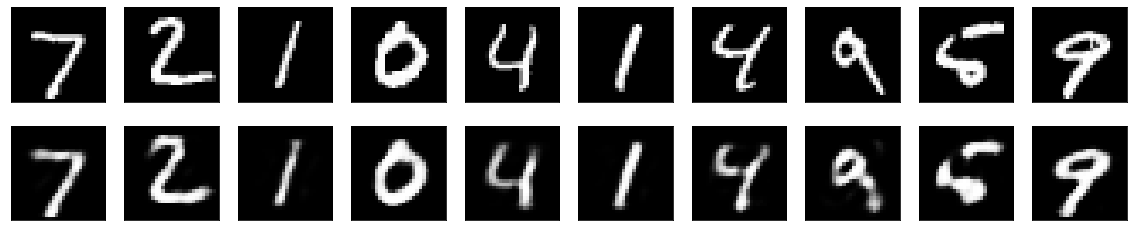

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
